In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import yaml

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
data_root = Path(r'/content/drive/MyDrive/archive (5)')
output_root = Path(r'/content/drive/MyDrive/fabric_yolo_dataset')

# Create output directories
train_dir = output_root / 'train'
val_dir = output_root / 'val'
test_dir = output_root / 'test'

for dir_path in [train_dir, val_dir, test_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Dataset root: {data_root}")
print(f"Output directory: {output_root}")

Dataset root: /content/drive/MyDrive/archive (5)
Output directory: /content/drive/MyDrive/fabric_yolo_dataset


In [ ]:
# Get all fabric categories (excluding Utilities folder)
fabric_categories = [d.name for d in data_root.iterdir()
                     if d.is_dir() and d.name not in ['Utilities', '.ipynb_checkpoints']]

fabric_categories.sort()

print(f"Total fabric categories: {len(fabric_categories)}")
print("\nFabric categories:")
for i, cat in enumerate(fabric_categories):
    print(f"{i}: {cat}")

Total fabric categories: 24

Fabric categories:
0: Acrylic
1: Artificial_fur
2: Artificial_leather
3: Blended
4: Chenille
5: Corduroy
6: Cotton
7: Crepe
8: Denim
9: Felt
10: Fleece
11: Leather
12: Linen
13: Lut
14: Nylon
15: Polyester
16: Satin
17: Silk
18: Suede
19: Terrycloth
20: Unclassified
21: Velvet
22: Viscose
23: Wool


In [ ]:
# Count samples per category
category_counts = {}
total_samples = 0

for category in fabric_categories:
    category_path = data_root / category
    sample_dirs = [d for d in category_path.iterdir() if d.is_dir()]
    category_counts[category] = len(sample_dirs)
    total_samples += len(sample_dirs)

# Create a dataframe for better visualization
df_counts = pd.DataFrame(list(category_counts.items()),
                         columns=['Category', 'Count']).sort_values('Count', ascending=False)

print(f"\nTotal samples across all categories: {total_samples}")
print("\nSamples per category:")
print(df_counts.to_string(index=False))


Total samples across all categories: 1969

Samples per category:
          Category  Count
            Cotton    588
           Blended    411
         Polyester    226
             Denim    162
      Unclassified    123
              Wool     90
             Nylon     57
              Silk     50
           Viscose     37
            Fleece     33
        Terrycloth     30
             Crepe     26
          Corduroy     24
             Satin     24
             Linen     19
           Leather     16
          Chenille     13
           Acrylic     12
            Velvet     11
             Suede      5
               Lut      4
              Felt      4
Artificial_leather      3
    Artificial_fur      1


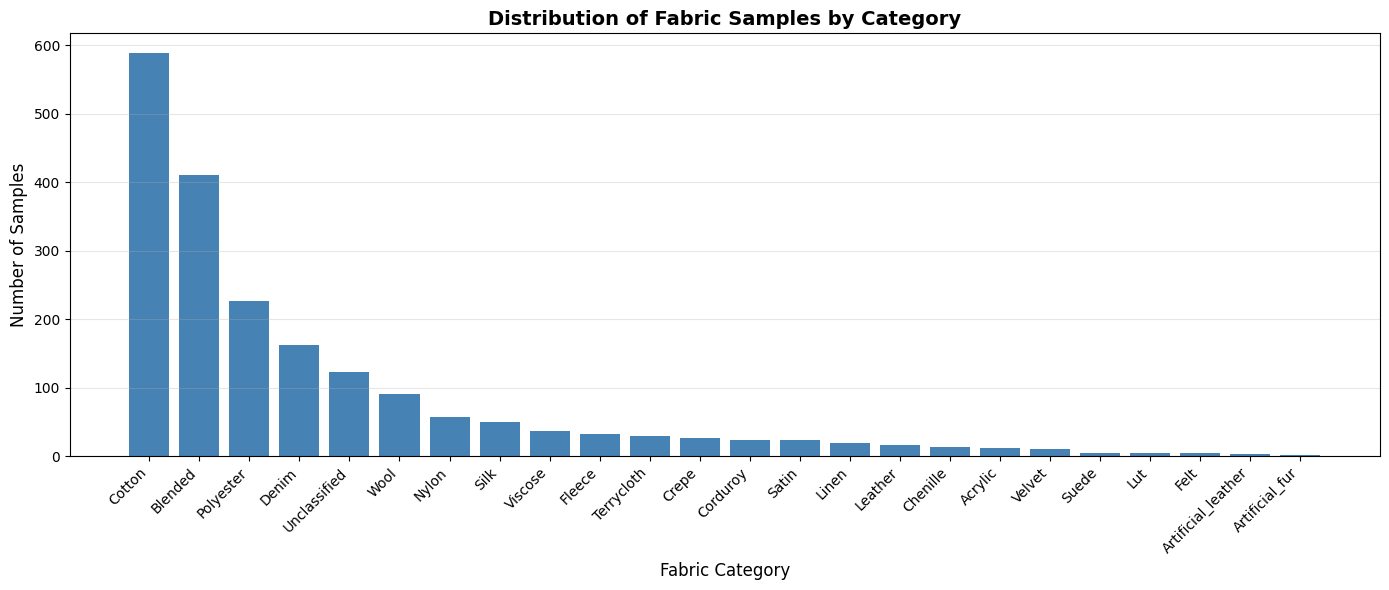

In [ ]:
# Visualize distribution
plt.figure(figsize=(14, 6))
plt.bar(df_counts['Category'], df_counts['Count'], color='steelblue')
plt.xlabel('Fabric Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Fabric Samples by Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Display sample images from different categories
def display_sample_images(num_categories=5, images_per_sample=4):
    sample_categories = random.sample(fabric_categories, min(num_categories, len(fabric_categories)))

    fig, axes = plt.subplots(num_categories, images_per_sample, figsize=(15, 3*num_categories))

    for idx, category in enumerate(sample_categories):
        category_path = data_root / category
        sample_dirs = [d for d in category_path.iterdir() if d.is_dir()]

        if sample_dirs:
            sample_dir = random.choice(sample_dirs)

            for img_idx in range(images_per_sample):
                img_path = sample_dir / f'im_{img_idx+1}.png'

                if img_path.exists():
                    img = Image.open(img_path)

                    if num_categories == 1:
                        axes[img_idx].imshow(img)
                        axes[img_idx].axis('off')
                        axes[img_idx].set_title(f'{category}\nIllumination {img_idx+1}')
                    else:
                        axes[idx, img_idx].imshow(img)
                        axes[idx, img_idx].axis('off')
                        axes[idx, img_idx].set_title(f'{category}\nIllumination {img_idx+1}')

    plt.tight_layout()
    plt.show()

display_sample_images(num_categories=5)

In [ ]:
def prepare_yolo_classification_dataset(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, use_all_images=True, min_samples=3):
    """
    Prepare dataset in YOLO classification format.

    Args:
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
        test_ratio: Proportion of data for testing
        use_all_images: If True, use all 4 illumination images. If False, use only im_1.png
        min_samples: Minimum number of samples required per category (default: 3)
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "Ratios must sum to 1.0"

    # Clear existing data
    if output_root.exists():
        shutil.rmtree(output_root)

    # Create class directories
    for split in ['train', 'val', 'test']:
        for category in fabric_categories:
            (output_root / split / category).mkdir(parents=True, exist_ok=True)

    # Process each category
    stats = {'train': 0, 'val': 0, 'test': 0}
    skipped_categories = []

    for category in fabric_categories:
        category_path = data_root / category
        sample_dirs = [d for d in category_path.iterdir() if d.is_dir()]

        # Skip categories with insufficient samples
        if len(sample_dirs) < min_samples:
            skipped_categories.append((category, len(sample_dirs)))
            print(f"WARNING: Skipping '{category}': only {len(sample_dirs)} sample(s) (minimum {min_samples} required)")
            continue

        # Split samples based on number available
        if len(sample_dirs) < 10:
            # For small categories, put at least 1 sample in each split
            train_samples = sample_dirs[:max(1, int(len(sample_dirs) * train_ratio))]
            remaining = sample_dirs[len(train_samples):]
            if len(remaining) >= 2:
                val_samples = remaining[:max(1, len(remaining)//2)]
                test_samples = remaining[len(val_samples):]
            else:
                val_samples = remaining
                test_samples = remaining  # Duplicate for very small datasets
        else:
            # Normal split for larger categories
            train_samples, temp_samples = train_test_split(sample_dirs, train_size=train_ratio, random_state=42)
            val_samples, test_samples = train_test_split(temp_samples,
                                                           train_size=val_ratio/(val_ratio+test_ratio),
                                                           random_state=42)

        splits = {
            'train': train_samples,
            'val': val_samples,
            'test': test_samples
        }

        # Copy images to respective directories
        for split_name, samples in splits.items():
            for sample_dir in samples:
                if use_all_images:
                    # Copy all 4 illumination images
                    for img_idx in range(1, 5):
                        src_img = sample_dir / f'im_{img_idx}.png'
                        if src_img.exists():
                            dst_img = output_root / split_name / category / f"{sample_dir.name}_im{img_idx}.png"
                            shutil.copy2(src_img, dst_img)
                            stats[split_name] += 1
                else:
                    # Copy only the first image
                    src_img = sample_dir / 'im_1.png'
                    if src_img.exists():
                        dst_img = output_root / split_name / category / f"{sample_dir.name}.png"
                        shutil.copy2(src_img, dst_img)
                        stats[split_name] += 1

    print("\n" + "="*60)
    print("Dataset preparation complete")
    print("="*60)
    print(f"\nDataset statistics:")
    print(f"  Training images: {stats['train']}")
    print(f"  Validation images: {stats['val']}")
    print(f"  Test images: {stats['test']}")
    print(f"  Total images: {sum(stats.values())}")

    if skipped_categories:
        print(f"\nSkipped {len(skipped_categories)} category/categories with insufficient samples:")
        for cat, count in skipped_categories:
            print(f"     - {cat}: {count} sample(s)")

    print(f"\nUsing {len(fabric_categories) - len(skipped_categories)} categories for training")
    print("="*60)

    return stats

# Prepare dataset (using all 4 images per sample for more data)
stats = prepare_yolo_classification_dataset(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, use_all_images=True)


Dataset preparation complete

Dataset statistics:
  Training images: 5468
  Validation images: 1192
  Test images: 1216
  Total images: 7876

Skipped 1 category/categories with insufficient samples:
     - Artificial_fur: 1 sample(s)

Using 23 categories for training


In [ ]:
# Create YAML config file for YOLO
# Only include categories that actually have images in the dataset
valid_categories = []
for category in fabric_categories:
    if (output_root / 'train' / category).exists() and list((output_root / 'train' / category).glob('*.png')):
        valid_categories.append(category)

yaml_config = {
    'path': str(output_root.absolute()),
    'train': 'train',
    'val': 'val',
    'test': 'test',
    'names': {i: name for i, name in enumerate(valid_categories)}
}

yaml_path = output_root / 'fabric_dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YAML configuration saved to: {yaml_path}")
print(f"Number of valid categories: {len(valid_categories)}")
print("\nYAML content:")
with open(yaml_path, 'r') as f:
    print(f.read())

YAML configuration saved to: /content/drive/MyDrive/fabric_yolo_dataset/fabric_dataset.yaml
Number of valid categories: 23

YAML content:
names:
  0: Acrylic
  1: Artificial_leather
  2: Blended
  3: Chenille
  4: Corduroy
  5: Cotton
  6: Crepe
  7: Denim
  8: Felt
  9: Fleece
  10: Leather
  11: Linen
  12: Lut
  13: Nylon
  14: Polyester
  15: Satin
  16: Silk
  17: Suede
  18: Terrycloth
  19: Unclassified
  20: Velvet
  21: Viscose
  22: Wool
path: /content/drive/MyDrive/fabric_yolo_dataset
test: test
train: train
val: val



In [ ]:


model = YOLO('yolo11m-cls.pt', task='classify')
model.to('cpu')

print("Model loaded successfully on CPU")
print("\nModel information:")
print(model.info())


Model loaded successfully on CPU

Model information:
YOLO11m-cls summary: 106 layers, 11,634,216 parameters, 0 gradients, 40.6 GFLOPs
(106, 11634216, 0, 40.6263808)


In [ ]:
dataset_dir = Path("/content/drive/MyDrive/fabric_yolo_dataset")  # Must contain 'train/' and 'val/' subfolders
model_path = "yolo11m-cls.pt"  # Classification model

# Training parameters
EPOCHS = 20
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = "cpu"  # Use CPU since no GPU available

# Load model
model = YOLO(model_path)

# Train the model
results = model.train(
    data=str(dataset_dir),        # Directory, not a .yaml file
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    project="fabric_classification",
    name="yolov11m_fabric",
    patience=10,
    save=True,
    plots=True,
    verbose=True,
    pretrained=True,
    optimizer="auto",
    lr0=0.01,
    weight_decay=0.0005
)

print("\n✅ Training complete. Results saved in 'fabric_classification/yolov11m_fabric'")

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/fabric_yolo_dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11m_fabric, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspect

In [ ]:
# Validate the model on the validation set
metrics = model.val(data=str(yaml_path), split='val')

print("\nValidation Metrics:")
print(f"Top-1 Accuracy: {metrics.top1:.4f}")
print(f"Top-5 Accuracy: {metrics.top5:.4f}")

In [ ]:
# Test the model on the test set
test_metrics = model.val(data=str(yaml_path), split='test')

print("\nTest Metrics:")
print(f"Top-1 Accuracy: {test_metrics.top1:.4f}")
print(f"Top-5 Accuracy: {test_metrics.top5:.4f}")

In [ ]:
def predict_and_visualize(image_path, model, class_names):
    """
    Make prediction and visualize result
    """
    # Make prediction
    results = model.predict(image_path, verbose=False)

    # Get prediction details
    result = results[0]
    top5_indices = result.probs.top5
    top5_conf = result.probs.top5conf.cpu().numpy()

    # Load and display image
    img = Image.open(image_path)

    plt.figure(figsize=(12, 4))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[top5_indices[0]]}\nConfidence: {top5_conf[0]:.2%}')

    # Display top-5 predictions
    plt.subplot(1, 2, 2)
    top5_labels = [class_names[i] for i in top5_indices]
    plt.barh(range(5), top5_conf[::-1], color='steelblue')
    plt.yticks(range(5), top5_labels[::-1])
    plt.xlabel('Confidence')
    plt.title('Top-5 Predictions')
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

    return top5_labels[0], top5_conf[0]

# Get some test images
test_images = list((output_root / 'test').rglob('*.png'))[:5]

print(f"Testing on {len(test_images)} sample images:\n")

for img_path in test_images:
    true_label = img_path.parent.name
    print(f"\nTrue label: {true_label}")
    predicted_label, confidence = predict_and_visualize(img_path, model, fabric_categories)
    print(f"Predicted: {predicted_label} ({confidence:.2%})")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_detailed(model, test_dir, class_names):
    """
    Generate detailed evaluation metrics
    """
    y_true = []
    y_pred = []

    # Get all test images
    test_images = list(test_dir.rglob('*.png'))

    print(f"Evaluating on {len(test_images)} test images...")

    for img_path in test_images:
        true_label = img_path.parent.name
        true_idx = class_names.index(true_label)

        # Make prediction
        results = model.predict(str(img_path), verbose=False)
        pred_idx = results[0].probs.top1

        y_true.append(true_idx)
        y_pred.append(pred_idx)

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix - Fabric Classification', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, cm

# Evaluate model
y_true, y_pred, cm = evaluate_model_detailed(model, test_dir, fabric_categories)